<a href="https://colab.research.google.com/github/Hoggnation/cataloging_coherent_oscillators/blob/main/Chi_Squared_Function_on_KIC_7917485.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lightkurve
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from astropy import units as u

In [3]:
#this means only look at top ten frequencies/peaks
num_of_peaks = 10

In [4]:
search_result = lk.search_lightcurve('KIC 7917485', mission='Kepler')
lc_collection = search_result.download_all()

In [5]:
#create a delta f (1/tmax-min aka 1/total observation time
#delta_f = 1/lc.time[-1] - lc.time[0] #this is in days
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
print(total_observation_time)
delta_f = (1/total_observation_time) ###frequency resolution in data

1470.4623264496477


In [6]:
#this is cutting off at a low frequency, could be higher freq
sampling_rate_days= np.median(np.diff(lc.time.value))
f_max = 0.5*(1 / (sampling_rate_days))
print(f_max)

24.469439731620103


In [7]:
f_min = delta_f/3
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

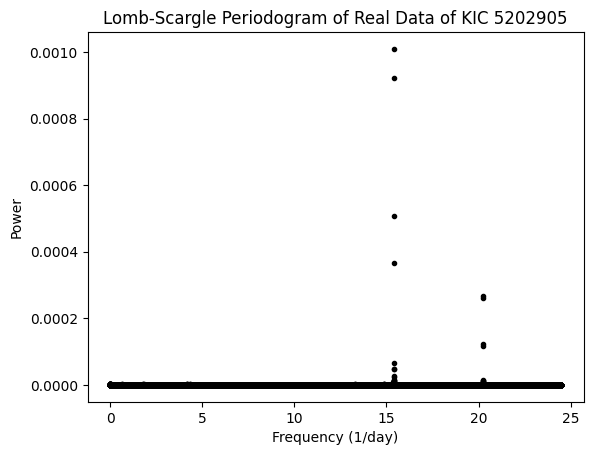

In [8]:
##Doing the same thing with real data

#time is in days


pg_real = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

real_power = pg_real.power.value
real_freq = pg_real.frequency.to(1/u.day).value

plt.plot(real_freq, real_power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of Real Data of KIC 5202905")
plt.show()

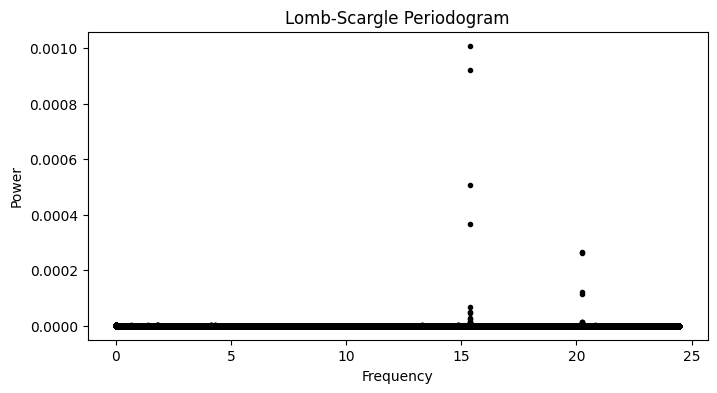

In [9]:
#trying to create periodograms of spacing f_min
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day) #spacing with increments of f_min, starting with f_min_no_units to avoid di

#create periodogram only to get values in order to remove units
pg_spacing_fmin = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid  # Unitless frequency grid
)

freq_values = pg_spacing_fmin.frequency.to(1/u.day).value  # Remove units
power_values = pg_spacing_fmin.power.value  # Remove units

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq_values, power_values, 'k.', lw=0.8)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()

In [10]:
import numpy as np
from scipy.signal import find_peaks

In [11]:
def get_started(num_of_peaks, xs, ys):
    """

    Identifies and returns the indices of the highest peaks in a given dataset.

    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array


    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

In [12]:
indices = get_started(num_of_peaks, freq_values, power_values)
print(indices)

[67859 89386 67855 67864 67852 67867 89391 89382 67849 67870]


In [13]:
def check_inputs(xs):
    """

    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.

    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

In [14]:
def reorder_inputs(xs,ys):
    """

    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length

    """
    i = np.argsort(xs)
    return xs[i], ys[i]


In [15]:
#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist):
    """

    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered

    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

In [16]:
def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak


    Returns:
        tuple: (b, m, q)

    Bugs:
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array


    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

In [17]:
def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak

    Returns:
        tuple: (x position of refined peak, y position of refined peak)

    Bugs:
        Must be synchronized with the design matrix


    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b

In [18]:
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        tuple of numpy arrays (array of refined x positions, array of refined y positions


    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined)

In [19]:
new_freqs, new_powers = refine_peaks(freq_values, power_values, indices) # this returns the new x values
#and the new y values

In [20]:
print (new_freqs, new_powers)

[15.3829968  20.26289502 15.3820062  15.38401359 15.38132149 15.38470733
 20.26390349 20.26189255 15.38064389 15.3853821 ] [1.04569644e-03 2.83069210e-04 4.78272559e-05 4.71332751e-05
 1.50167616e-05 1.37478492e-05 1.34720758e-05 1.29299733e-05
 7.84976874e-06 7.51094194e-06]


In [21]:
#originally the new positions function was returning the refined peaks and powers as seperate arrays, now they are arranged as tuples so that the zip function works
new_freqs, new_powers = refine_peaks(freq_values, power_values, indices)
new_positions = list(zip(new_freqs, new_powers))
refined_frequencies, refined_powers = zip(*new_positions)

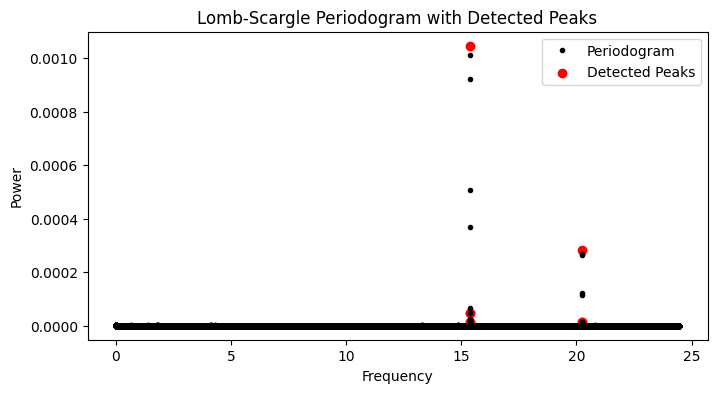

In [22]:
plt.figure(figsize=(8, 4))

plt.plot(freq_values, power_values, 'k.', lw=0.8, label="Periodogram")

plt.scatter(refined_frequencies, refined_powers, color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram with Detected Peaks")
plt.legend()

plt.show()

In [23]:
search_result = lk.search_lightcurve('KIC 7917485', mission='Kepler')
lc_collection = search_result.download_all()

In [24]:
#array of time differences, find its median, use it to calculate the max frequency
lc = lc_collection.stitch()  # Combine all light curves in lc_collection
sampling_rate_days= np.median(np.diff(lc.time))
sampling_rate_days_no_units = sampling_rate_days.value #get rid of units
f_max = 1 / (sampling_rate_days) #in days
f_max_no_units = f_max.value #get rid of units (but it's actually in 1/days)

print(sampling_rate_days_no_units)
print(f_max_no_units)
print(sampling_rate_days)

0.02043365134159103
48.938879463240205
0.02043365134159103


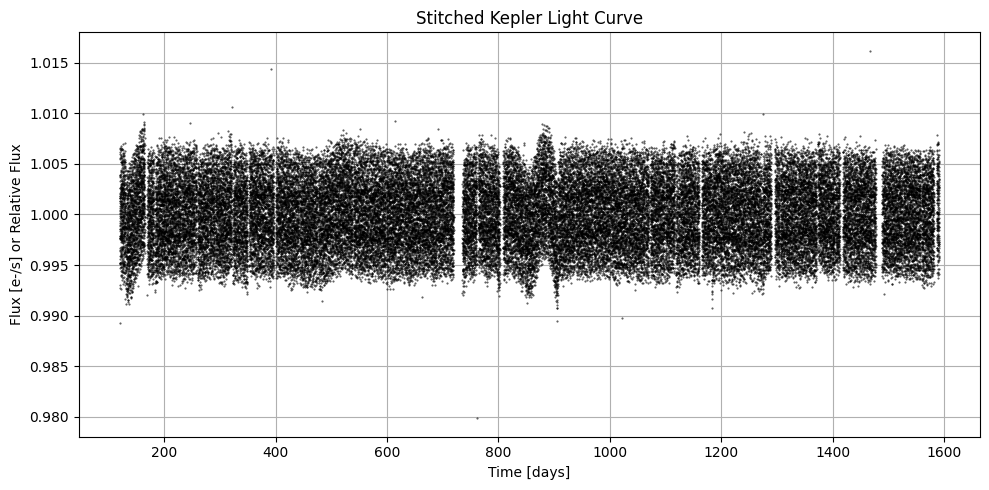

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(lc.time.value, lc.flux.value, 'k.', markersize=1, alpha=0.7)
plt.xlabel("Time [days]")
plt.ylabel("Flux [e-/s] or Relative Flux")
plt.title("Stitched Kepler Light Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Arrays for time, flux, uncertainity, and selecting our frequency from the refined peaks
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value
max_power_index = np.argmax(new_powers)
nu = new_freqs[max_power_index]

In [27]:
print(nu)

15.382996803433912


In [28]:
print(t.shape, flux.shape, sigma.shape)

(65504,) (65504,) (65504,)


In [29]:
# Masking the arrays to ensure all arrays are the same length(had error due to unmatched data lengths)
t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = ~np.isnan(t_clean) & ~np.isnan(flux_clean) & ~np.isnan(sigma_clean) #good

t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]



In [30]:
print(t_fit.shape, flux_fit.shape, sigma_fit.shape)

(65266,) (65266,) (65266,)


In [31]:
print(t_fit.max(), flux_fit.max(), sigma_fit.max())

1591.0007908573243 1.0161732 0.00012699235


In [32]:
import numpy as np

omega = 2 * np.pi * nu

# Design matrix
A_matrix = np.vstack([
    np.ones_like(t_fit),
    np.cos(omega * t_fit),
    np.sin(omega * t_fit)
]).T

# Weights
weights = 1 / sigma_fit**2

# Debug shapes
print("A_matrix shape:", A_matrix.shape)
print("weights shape:", weights.shape)

# Weighted least squares
ATA = A_matrix.T @ (A_matrix * weights[:, np.newaxis])
ATy = A_matrix.T @ (flux_fit * weights)

try:
    g = np.linalg.solve(ATA, ATy)
    model_flux = A_matrix @ g
    print("Fit coefficients (C, A, B):", g)
except np.linalg.LinAlgError as e:
    print("Matrix inversion failed:", e)


A_matrix shape: (65266, 3)
weights shape: (65266,)
Fit coefficients (C, A, B): [ 1.00003296 -0.00272339  0.00304857]


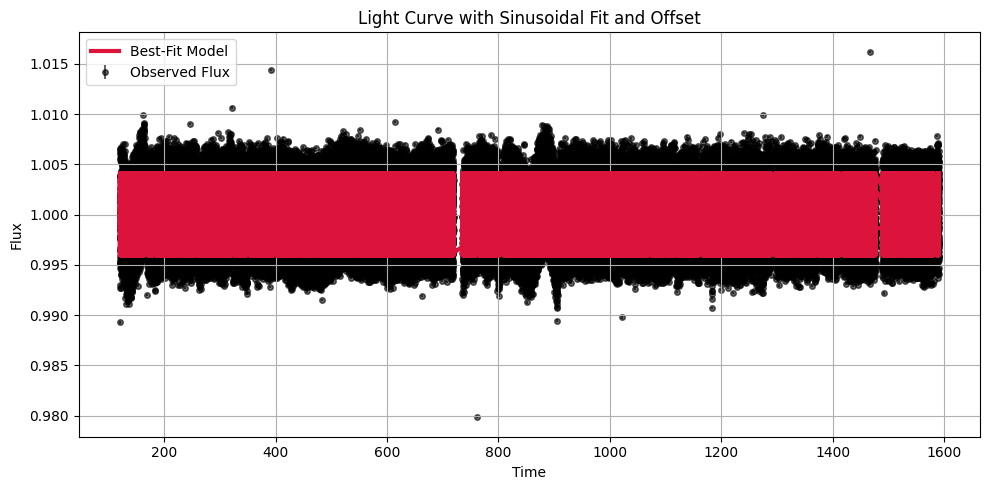

In [33]:
plt.figure(figsize=(10, 5))

# Plot observed flux (data)
plt.errorbar(
    t_fit, flux_fit, yerr=sigma_fit, fmt='o',
    label='Observed Flux', alpha=0.6, color='black', markersize=4, zorder=1
)

# Plot best-fit model (bold and on top)
plt.plot(
    t_fit, model_flux, color='crimson',
    label='Best-Fit Model', linewidth=3, zorder=2
)

# Labels and styling
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Light Curve with Sinusoidal Fit and Offset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

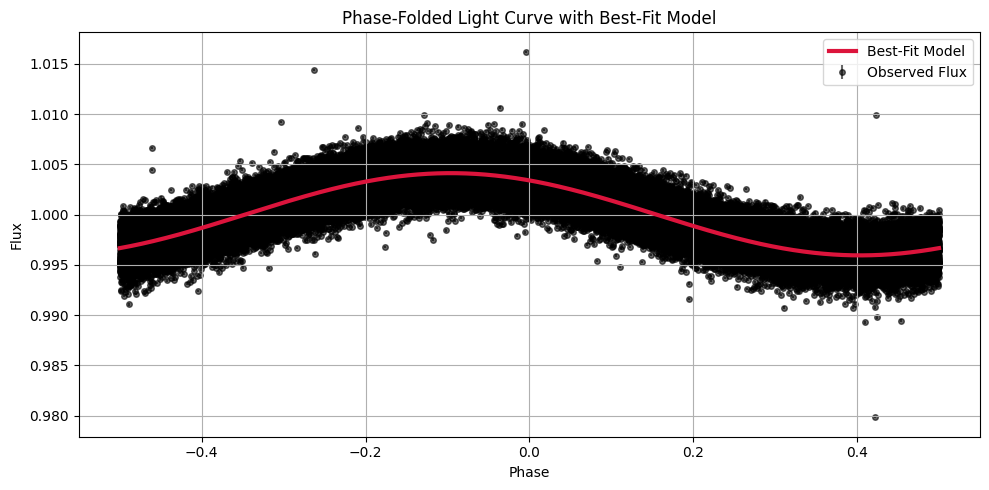

In [34]:
# Compute period from selected frequency
P = 1 / new_freqs[max_power_index]

# Reference time
t0 = t_fit[np.argmin(flux)] #this should center the phase around zero?

# phase folding over the select period
phase = ((t_fit - t0) % P) / P
phase[phase > 0.5] -= 1 # shifting range


# Sort for better plotting // i think data may already be sorted
sorted_indices = np.argsort(phase)
phase_sorted = phase[sorted_indices]
flux_sorted = flux_fit[sorted_indices]
sigma_sorted = sigma_fit[sorted_indices]
model_sorted = model_flux[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(
    phase_sorted, flux_sorted, yerr=sigma_sorted, fmt='o',
    label='Observed Flux', alpha=0.6, color='black', markersize=4, zorder=1
)
plt.plot(
    phase_sorted, model_sorted, color='crimson',
    label='Best-Fit Model', linewidth=3, zorder=2
)

# Labels and styling
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Phase-Folded Light Curve with Best-Fit Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



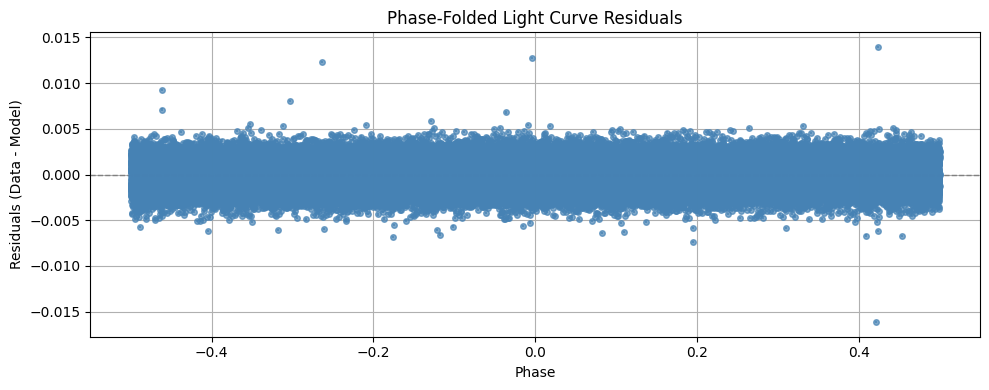

In [35]:
# Calculate residuals
residuals = flux_sorted - model_sorted

# Plot residuals
plt.figure(figsize=(10, 4))
plt.errorbar(
    phase_sorted, residuals, yerr=sigma_sorted, fmt='o',
    color='steelblue', alpha=0.7, markersize=4
)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Labels and styling
plt.xlabel('Phase')
plt.ylabel('Residuals (Data - Model)')
plt.title('Phase-Folded Light Curve Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


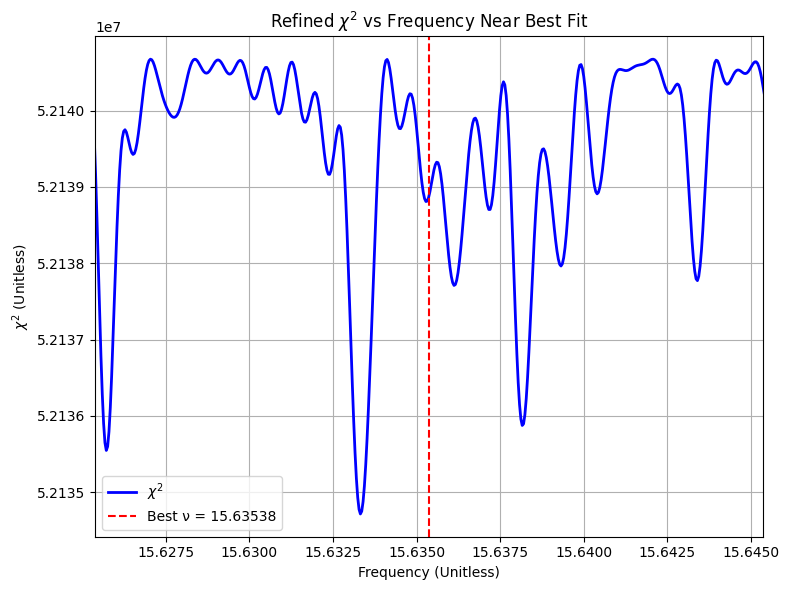

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define fine frequency grid around best_nu (extended range)
fine_freqs = np.linspace(nu - 0.02, nu + 0.02, 1000)  # Adjusted range around nu
chi2_fine = []

# Step 2: Compute chi^2 for each frequency
for freq in fine_freqs:
    omega = 2 * np.pi * freq
    A_matrix = np.vstack([
        np.ones_like(t_fit),
        np.cos(omega * t_fit),
        np.sin(omega * t_fit)
    ]).T

    weights = 1 / sigma_fit**2
    ATA = A_matrix.T @ (A_matrix * weights[:, np.newaxis])
    ATy = A_matrix.T @ (flux_fit * weights)

    try:
        g = np.linalg.solve(ATA, ATy)
        model_flux = A_matrix @ g
        residuals = flux_fit - model_flux
        chi2 = np.sum((residuals / sigma_fit)**2)
    except np.linalg.LinAlgError:
        chi2 = np.nan
        print(f"Warning: Matrix inversion failed at frequency {freq:.5f} Hz.")

    # Append the chi-squared value (including NaN if error occurs)
    chi2_fine.append(chi2)

# Convert list to numpy array for easy handling
chi2_fine = np.array(chi2_fine)

# Check if any NaNs are present in chi2_fine
if np.any(np.isnan(chi2_fine)):
    print("Warning: NaN values found in chi2_fine. These will be plotted as gaps.")

# Step 3: Plot refined chi^2 vs frequency
plt.figure(figsize=(8, 6))
plt.plot(fine_freqs, chi2_fine, 'b-', lw=2, label=r"$\chi^2$")
plt.axvline(nu, color='red', linestyle='--', label=f'Best ν = {nu:.5f}')

# Zooming in on the plot around the best frequency (nu)
plt.xlim(nu - 0.01, nu + 0.01)  # Adjust zooming range as needed

# Labels and title
plt.xlabel("Frequency (Unitless)")
plt.ylabel(r"$\chi^2$ (Unitless)")
plt.title(r"Refined $\chi^2$ vs Frequency Near Best Fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


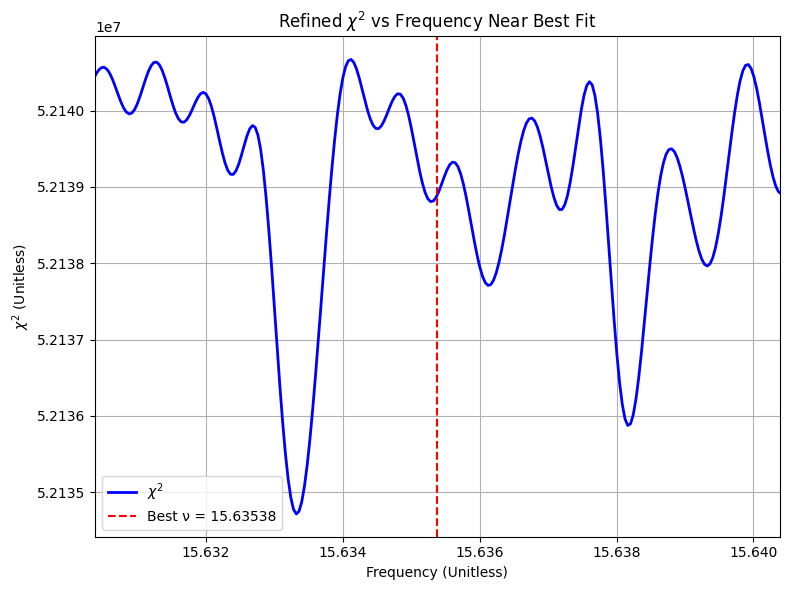

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define fine frequency grid around best_nu (extended range)
fine_freqs = np.linspace(nu - 0.02, nu + 0.02, 1000)  # Adjusted range around nu
chi2_fine = []

# Step 2: Compute chi^2 for each frequency
for freq in fine_freqs:
    omega = 2 * np.pi * freq
    A_matrix = np.vstack([
        np.ones_like(t_fit),
        np.cos(omega * t_fit),
        np.sin(omega * t_fit)
    ]).T

    weights = 1 / sigma_fit**2
    ATA = A_matrix.T @ (A_matrix * weights[:, np.newaxis])
    ATy = A_matrix.T @ (flux_fit * weights)

    try:
        g = np.linalg.solve(ATA, ATy)
        model_flux = A_matrix @ g
        residuals = flux_fit - model_flux
        chi2 = np.sum((residuals / sigma_fit)**2)
    except np.linalg.LinAlgError:
        chi2 = np.nan
        print(f"Warning: Matrix inversion failed at frequency {freq:.5f} Hz.")

    # Append the chi-squared value (including NaN if error occurs)
    chi2_fine.append(chi2)

# Convert list to numpy array for easy handling
chi2_fine = np.array(chi2_fine)

# Check if any NaNs are present in chi2_fine
if np.any(np.isnan(chi2_fine)):
    print("Warning: NaN values found in chi2_fine. These will be plotted as gaps.")

# Step 3: Plot refined chi^2 vs frequency
plt.figure(figsize=(8, 6))
plt.plot(fine_freqs, chi2_fine, 'b-', lw=2, label=r"$\chi^2$")
plt.axvline(nu, color='red', linestyle='--', label=f'Best ν = {nu:.5f}')

# Zooming in on the plot around the best frequency (nu)
plt.xlim(nu - 0.005, nu + 0.005)  # Zooming in closer around nu

# Labels and title
plt.xlabel("Frequency (Unitless)")
plt.ylabel(r"$\chi^2$ (Unitless)")
plt.title(r"Refined $\chi^2$ vs Frequency Near Best Fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [90]:
# Find the index of the minimum chi-squared value
min_index = np.argmin(chi2_fine)  # Index of minimum chi-squared

# Define the new frequency (the one that gives the minimum chi-squared)
new_frequency = fine_freqs[min_index]

# Output the result
print(f"New frequency that minimizes chi-squared: {new_frequency:.5f} Hz")


New frequency that minimizes chi-squared: 15.63332 Hz
